In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# 加载数据集
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

100.0%
100.0%
100.0%
100.0%


In [2]:
# 定义编码器
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc21 = nn.Linear(256, 20) # 均值向量
        self.fc22 = nn.Linear(256, 20) # 方差向量

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 128 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        mean = self.fc21(x)
        log_var = self.fc22(x)
        return mean, log_var


# 定义解码器
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(20, 256)
        self.fc2 = nn.Linear(256, 128 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.sigmoid(self.conv3(x))
        return x


# 定义VAE模型
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mean

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        x_recon = self.decoder(z)
        return x_recon, mean, log_var

    def loss_function(self, x_recon, x, mean, log_var):
        recon_loss = nn.functional.binary_cross_entropy(x_recon, x, size_average=False)
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return recon_loss + kl_loss

    def sample(self, num_samples):
        z = torch.randn(num_samples, 20)
        samples = self.decoder(z)
        return samples

In [3]:
# 定义优化器
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# 开始训练模型
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        x_recon, mean, log_var = vae(data)
        loss = vae.loss_function(x_recon, data, mean, log_var)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'.format(
                epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.data.item()))

D:\Anaconda\envs\pytorch\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/10], Batch [1/469], Loss: 67656.2578
Epoch [1/10], Batch [101/469], Loss: 25178.3613
Epoch [1/10], Batch [201/469], Loss: 20013.4414
Epoch [1/10], Batch [301/469], Loss: 17477.5176
Epoch [1/10], Batch [401/469], Loss: 16301.6191
Epoch [2/10], Batch [1/469], Loss: 15652.1396
Epoch [2/10], Batch [101/469], Loss: 14382.5312
Epoch [2/10], Batch [201/469], Loss: 15010.9219
Epoch [2/10], Batch [301/469], Loss: 14301.9561
Epoch [2/10], Batch [401/469], Loss: 14165.0498
Epoch [3/10], Batch [1/469], Loss: 14068.8340
Epoch [3/10], Batch [101/469], Loss: 14018.7070
Epoch [3/10], Batch [201/469], Loss: 13756.9893
Epoch [3/10], Batch [301/469], Loss: 13159.7383
Epoch [3/10], Batch [401/469], Loss: 13314.3350
Epoch [4/10], Batch [1/469], Loss: 13195.5928
Epoch [4/10], Batch [101/469], Loss: 13133.1738
Epoch [4/10], Batch [201/469], Loss: 13540.6943
Epoch [4/10], Batch [301/469], Loss: 13435.3828
Epoch [4/10], Batch [401/469], Loss: 13326.8242
Epoch [5/10], Batch [1/469], Loss: 13630.0342
Ep

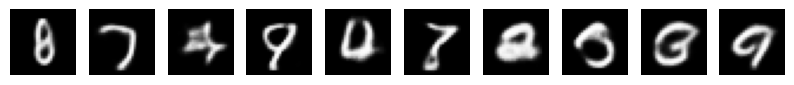

In [4]:
from matplotlib import pyplot as plt

# 生成手写数字图像
samples = vae.sample(10)
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].imshow(samples[i].detach().numpy().reshape(28, 28), cmap='gray')
    ax[i].axis('off')
plt.show()